In [1]:
# Classical Trading Strategy - Production Implementation
# 
# This notebook demonstrates the complete production-ready trading strategy
# that combines NeuroTrend Intelligent, Market Bias, and Intelligent Chop indicators

import pandas as pd
import numpy as np
import time
import sys
from datetime import timedelta
from pathlib import Path

# Add parent directory to path for imports
sys.path.append('..')

# Import strategy components
from strategy_code.Prod_strategy import create_optimized_strategy
from strategy_code.Prod_plotting import plot_production_results
from technical_indicators_custom import TIC

# Set display options
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 120)

print("Classical Trading Strategy - Optimized Production Version")
print("=" * 80)

Classical Trading Strategy - Optimized Production Version


## 1. Load and Prepare Data

First, we'll load the forex data and calculate all required technical indicators.

In [2]:
# Load AUDUSD 15M data
print("Loading AUDUSD 15M data...")
df = pd.read_csv('../data/AUDUSD_MASTER_15M.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)

print(f"Total dataset: {len(df):,} rows")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"Duration: {(df.index[-1] - df.index[0]).days} days")

# Display basic statistics
print("\nPrice Statistics:")
print(df[['Open', 'High', 'Low', 'Close']].describe())

Loading AUDUSD 15M data...
Total dataset: 181,287 rows
Date range: 2018-01-01 17:00:00 to 2025-05-30 16:45:00
Duration: 2705 days

Price Statistics:
                Open           High            Low          Close
count  181287.000000  181287.000000  181287.000000  181287.000000
mean        0.697128       0.697434       0.696820       0.697128
std         0.044472       0.044457       0.044486       0.044472
min         0.554140       0.555220       0.550680       0.554050
25%         0.662540       0.662800       0.662260       0.662540
50%         0.693070       0.693410       0.692760       0.693070
75%         0.727440       0.727740       0.727140       0.727445
max         0.813350       0.813570       0.812800       0.813370


## 2. Calculate Technical Indicators

The strategy requires three main indicators:
- **NeuroTrend Intelligent**: Advanced trend detection with confidence scoring
- **Market Bias**: Market structure analysis using Heiken Ashi
- **Intelligent Chop**: Market regime classification (trending vs ranging)

In [4]:
# Select a sample for faster processing (or use full dataset)
# For demonstration, we'll use the last 2 years
end_date = df.index[-1]
start_date = end_date - timedelta(days=2*365)
df_test = df[df.index >= start_date].copy()

print(f"\nTest Period: {df_test.index[0]} to {df_test.index[-1]}")
print(f"Test Bars: {len(df_test):,}")

# Calculate indicators
print("\nCalculating indicators...")
start_time = time.time()

# 1. NeuroTrend Intelligent
df_test = TIC.add_neuro_trend_intelligent(
    df_test, 
    base_fast=10, 
    base_slow=50, 
    confirm_bars=3
)

# 2. Market Bias
df_test = TIC.add_market_bias(
    df_test, 
    ha_len=350,  # Longer period for stability
    ha_len2=30   # Shorter period for responsiveness
)

# 3. Intelligent Chop
df_test = TIC.add_intelligent_chop(df_test)

# 4. Additional columns needed by optimized strategy
df_test['IC_ATR_MA'] = df_test['IC_ATR_Normalized'].rolling(20).mean()
df_test['NTI_Strength'] = abs(df_test['NTI_Direction'].rolling(5).mean())

indicator_time = time.time() - start_time
print(f"Indicators calculated in {indicator_time:.2f}s")

# Display indicator columns
print("\nIndicator columns added:")
print(f"- NeuroTrend: {[col for col in df_test.columns if col.startswith('NTI_')]}")
print(f"- Market Bias: {[col for col in df_test.columns if col.startswith('MB_')]}")
print(f"- Intelligent Chop: {[col for col in df_test.columns if col.startswith('IC_')]}")


Test Period: 2023-05-31 16:45:00 to 2025-05-30 16:45:00
Test Bars: 48,546

Calculating indicators...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Indicators calculated in 2.18s

Indicator columns added:
- NeuroTrend: ['NTI_FastEMA', 'NTI_SlowEMA', 'NTI_SlopePower', 'NTI_TrendPhase', 'NTI_DirectionRaw', 'NTI_Direction', 'NTI_Confidence', 'NTI_ReversalRisk', 'NTI_StallDetected', 'NTI_SlopeForecast', 'NTI_Strength']
- Market Bias: ['MB_h2', 'MB_l2', 'MB_ha_avg', 'MB_Bias', 'MB_o2', 'MB_c2']
- Intelligent Chop: ['IC_Regime', 'IC_RegimeName', 'IC_Confidence', 'IC_ADX', 'IC_ChoppinessIndex', 'IC_BandWidth', 'IC_ATR_Normalized', 'IC_EfficiencyRatio', 'IC_DI_Plus', 'IC_DI_Minus', 'IC_BB_Upper', 'IC_BB_Middle', 'IC_BB_Lower', 'IC_Signal', 'IC_RiskLevel', 'IC_ATR_MA']


## 3. Visualize Indicators

Let's plot the three indicators together to see how they interact:

Plotting sample from 2023-12-14 12:30:00 to 2023-12-29 13:15:00


<Figure size 2000x1000 with 0 Axes>

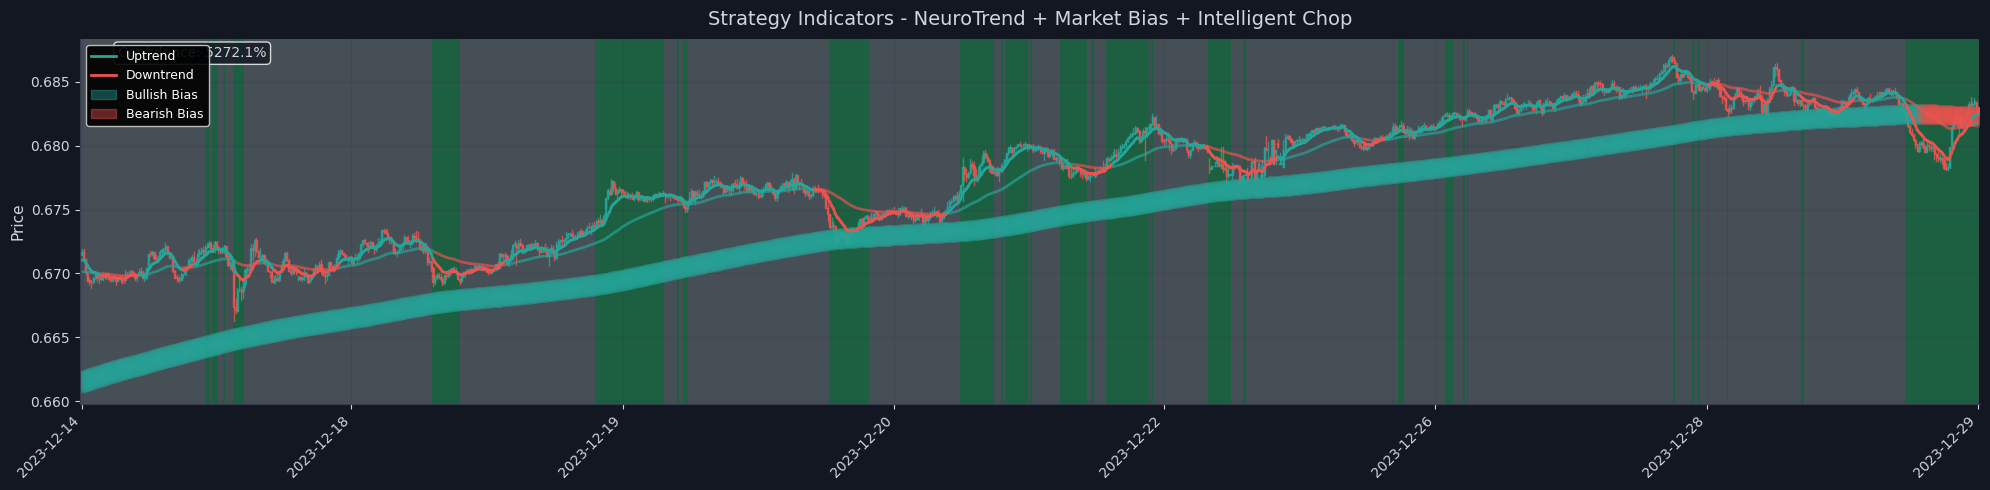

In [5]:
# Plot a sample of the indicators
from technical_indicators_custom.plotting import plot_neurotrend_market_bias_chop

# Select a random 1000-bar sample for visualization
sample_size = 1000
max_start = len(df_test) - sample_size
random_start = np.random.randint(0, max_start)
df_sample = df_test.iloc[random_start:random_start + sample_size].copy()

print(f"Plotting sample from {df_sample.index[0]} to {df_sample.index[-1]}")

# Create combined indicator plot
fig = plot_neurotrend_market_bias_chop(
    df_sample,
    title="Strategy Indicators - NeuroTrend + Market Bias + Intelligent Chop",
    figsize=(20, 10),
    show=True,
    show_chop_subplots=False,
    use_chop_background=True,
    simplified_regime_colors=True,
    trend_color='#2ECC71',  # Green for trending
    range_color='#95A5A6'   # Grey for ranging
)

## 4. Run Backtest with Optimized Strategy

Now we'll run the optimized production strategy with all the enhancements:

In [6]:
# Create optimized strategy with all enhancements
print("Creating optimized strategy...")
strategy = create_optimized_strategy(
    # Capital and Risk
    initial_capital=100_000,
    risk_per_trade=0.02,  # 2% risk per trade
    
    # Stop Loss Configuration
    sl_max_pips=45.0,  # Maximum 45 pip stop loss
    sl_volatility_adjustment=True,  # Adjust for market volatility
    
    # Trailing Stop Configuration
    tsl_activation_pips=15,  # Activate after 15 pips profit
    tsl_min_profit_pips=5,   # Guarantee 5 pip minimum profit
    
    # Signal Flip Filters (Key Optimization)
    exit_on_signal_flip=True,
    signal_flip_min_profit_pips=5.0,  # Only exit if profitable
    signal_flip_min_time_hours=2.0,   # Minimum 2 hours in trade
    signal_flip_partial_exit_percent=0.5,  # Exit 50% on weak flips
    
    # Position Sizing
    intelligent_sizing=True,  # Use confidence-based sizing
    
    # Other Features
    partial_profit_before_sl=True,  # Take partial profit early
    relaxed_mode=False,  # Standard mode (all 3 indicators)
    verbose=False
)

print("\nStrategy Configuration:")
print(f"- Initial Capital: ${strategy.config.initial_capital:,}")
print(f"- Risk per Trade: {strategy.config.risk_per_trade*100}%")
print(f"- Max Stop Loss: {strategy.config.sl_max_pips} pips")
print(f"- TSL Activation: {strategy.config.tsl_activation_pips} pips")
print(f"- Signal Flip Filters: Active")
print(f"- Intelligent Sizing: {'Enabled' if strategy.config.intelligent_sizing else 'Disabled'}")

Creating optimized strategy...

Strategy Configuration:
- Initial Capital: $100,000
- Risk per Trade: 2.0%
- Max Stop Loss: 45.0 pips
- TSL Activation: 15 pips
- Signal Flip Filters: Active
- Intelligent Sizing: Enabled


In [7]:
# Run the backtest
print("\nRunning backtest...")
start_time = time.time()

results = strategy.run_backtest(df_test)

backtest_time = time.time() - start_time
print(f"\nBacktest completed in {backtest_time:.2f}s")
print(f"Processing speed: {len(df_test)/backtest_time:.0f} bars/second")

# Display key metrics
print("\n" + "="*60)
print("BACKTEST RESULTS")
print("="*60)
print(f"Total Trades:    {results['total_trades']}")
print(f"Winning Trades:  {results['winning_trades']} ({results['win_rate']:.1f}%)")
print(f"Losing Trades:   {results['losing_trades']}")
print(f"\nTotal P&L:       ${results['total_pnl']:,.2f}")
print(f"Total Return:    {results['total_return']:.2f}%")
print(f"Sharpe Ratio:    {results['sharpe_ratio']:.2f}")
print(f"Max Drawdown:    {results['max_drawdown']:.2f}%")
print(f"Profit Factor:   {results['profit_factor']:.2f}")
print(f"\nAverage Win:     ${results['avg_win']:,.2f}")
print(f"Average Loss:    ${results['avg_loss']:,.2f}")

# Exit reason breakdown
print("\nExit Reason Breakdown:")
for reason, count in sorted(results['exit_reasons'].items(), key=lambda x: x[1], reverse=True):
    percentage = (count / results['total_trades']) * 100
    print(f"  {reason:20} {count:4} ({percentage:5.1f}%)")


Running backtest...

Backtest completed in 1.38s
Processing speed: 35057 bars/second

BACKTEST RESULTS
Total Trades:    818
Winning Trades:  563 (68.8%)
Losing Trades:   255

Total P&L:       $420,416.66
Total Return:    420.42%
Sharpe Ratio:    0.24
Max Drawdown:    -30.48%
Profit Factor:   1.29

Average Win:     $3,326.17
Average Loss:    $-5,694.98

Exit Reason Breakdown:
  take_profit_1         448 ( 54.8%)
  stop_loss             318 ( 38.9%)
  signal_flip            30 (  3.7%)
  trailing_stop          21 (  2.6%)
  end_of_data             1 (  0.1%)


## 5. Visualize Trading Results

Let's create a comprehensive chart showing:
- Price action with trade entries/exits
- P&L curve
- Position sizes over time

Chart saved to charts/backtest_results.png


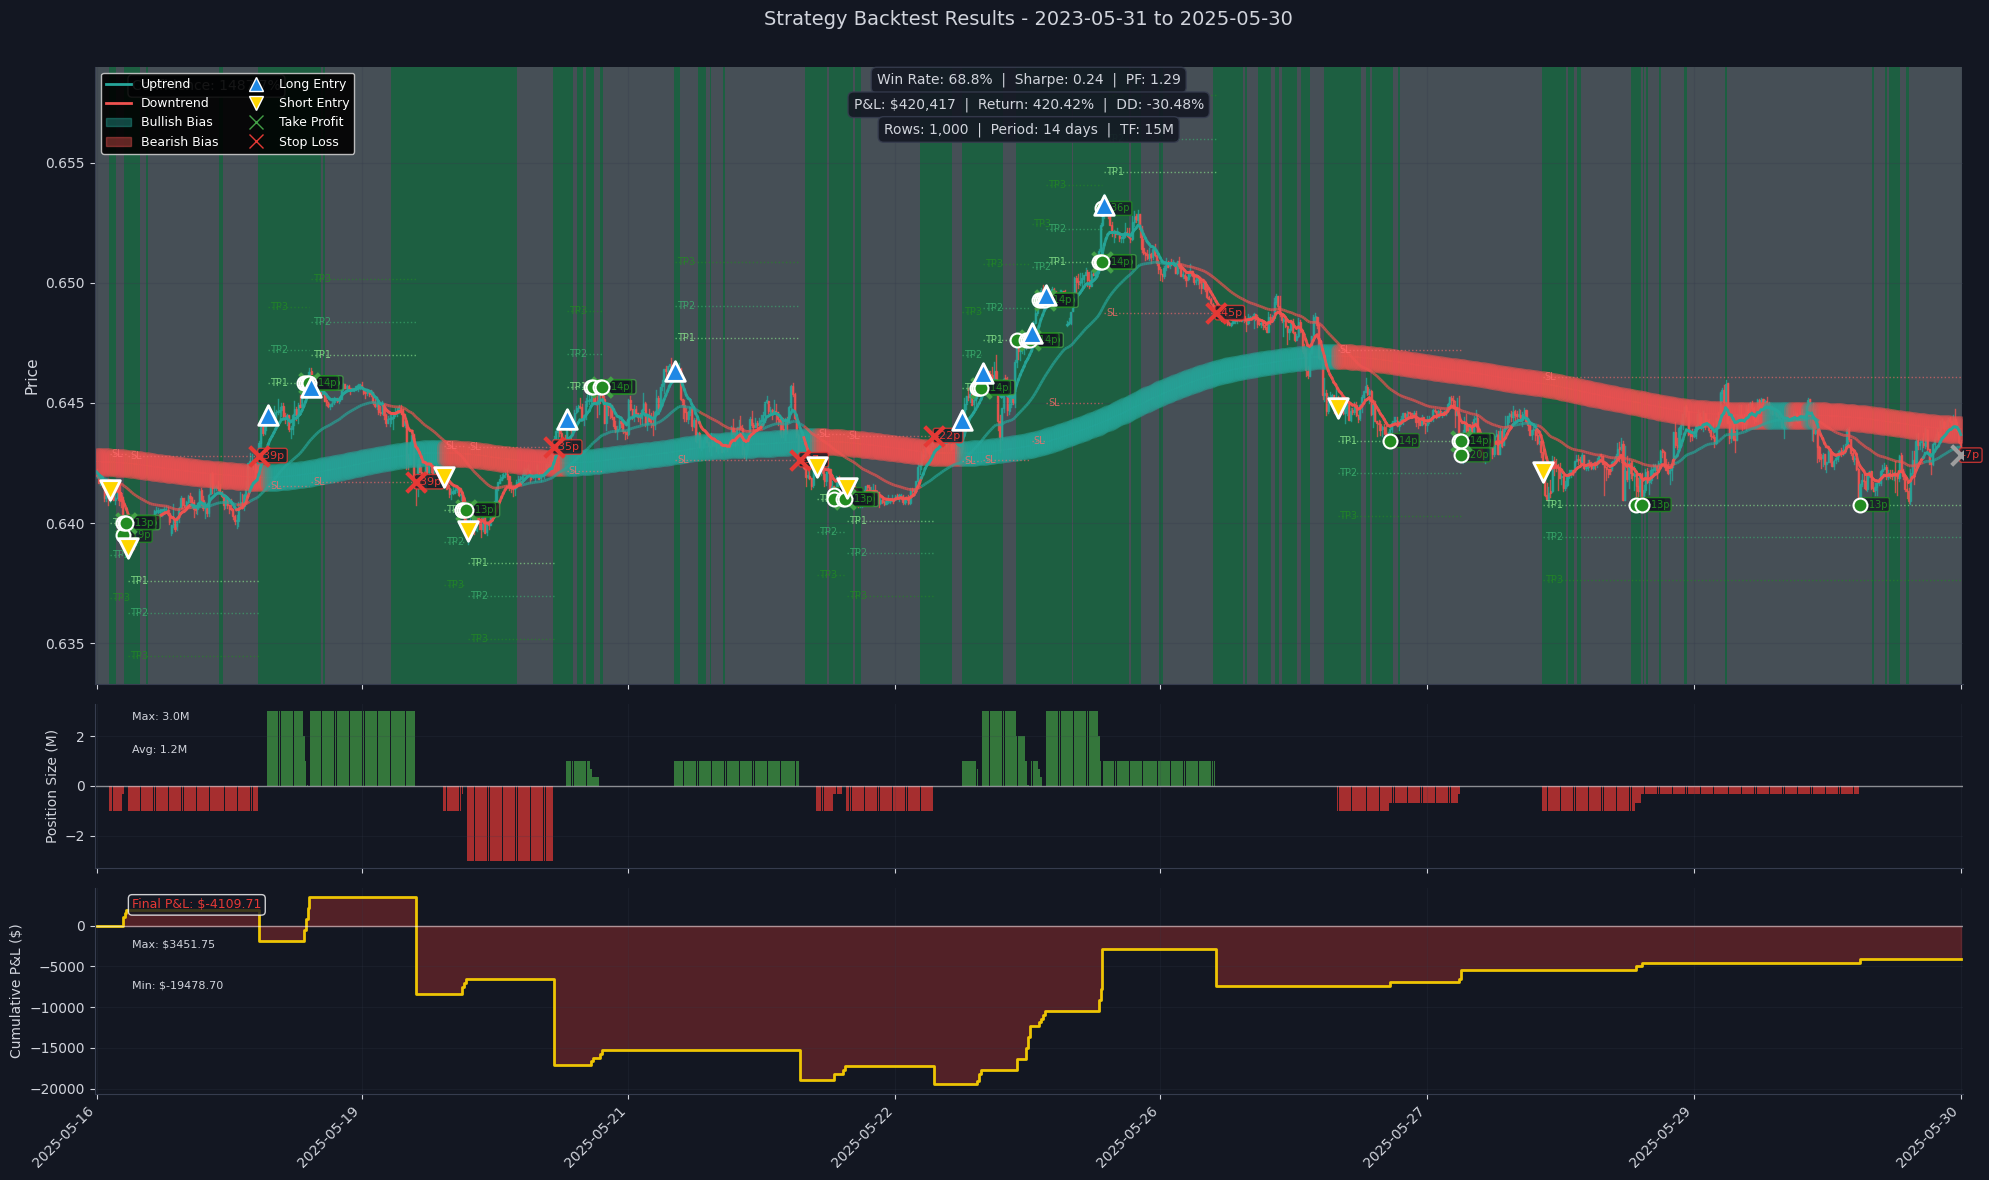


Chart saved to charts/backtest_results.png


In [8]:
# Create output directory for charts
Path("charts").mkdir(exist_ok=True)

# Plot the complete backtest results
fig = plot_production_results(
    df=df_test.tail(1000),  # Plot last 1000 bars for clarity
    results=results,
    title=f"Strategy Backtest Results - {df_test.index[0].strftime('%Y-%m-%d')} to {df_test.index[-1].strftime('%Y-%m-%d')}",
    show_pnl=True,
    show_position_sizes=True,
    figsize=(20, 14),
    save_path="charts/backtest_results.png",
    show=True
)

print("\nChart saved to charts/backtest_results.png")

## 6. Analyze Individual Trades

Let's examine some successful and unsuccessful trades to understand the strategy's behavior:

In [9]:
# Analyze winning and losing trades
trades_df = pd.DataFrame([{
    'entry_time': t.entry_time,
    'exit_time': t.exit_time,
    'direction': t.direction.value,
    'entry_price': t.entry_price,
    'exit_price': t.exit_price,
    'position_size_m': t.position_size / 1_000_000,
    'pnl': t.pnl,
    'exit_reason': t.exit_reason.value if t.exit_reason else 'unknown',
    'duration_hours': (t.exit_time - t.entry_time).total_seconds() / 3600 if t.exit_time else 0
} for t in results['trades']])

# Best trades
print("Top 5 Winning Trades:")
print(trades_df.nlargest(5, 'pnl')[['entry_time', 'direction', 'position_size_m', 'pnl', 'exit_reason', 'duration_hours']].round(2))

print("\nTop 5 Losing Trades:")
print(trades_df.nsmallest(5, 'pnl')[['entry_time', 'direction', 'position_size_m', 'pnl', 'exit_reason', 'duration_hours']].round(2))

# Trade duration analysis
print(f"\nTrade Duration Statistics:")
print(f"Average: {trades_df['duration_hours'].mean():.1f} hours")
print(f"Median: {trades_df['duration_hours'].median():.1f} hours")
print(f"Min: {trades_df['duration_hours'].min():.1f} hours")
print(f"Max: {trades_df['duration_hours'].max():.1f} hours")

Top 5 Winning Trades:
             entry_time direction  position_size_m       pnl    exit_reason  duration_hours
722 2025-04-04 06:45:00     short              5.0  15011.82  take_profit_1            0.75
297 2024-02-13 08:45:00      long              3.0  14722.10      stop_loss            0.25
608 2025-01-08 07:30:00     short              5.0  13350.19  take_profit_1           49.00
123 2023-09-04 22:45:00     short              5.0  12240.85  take_profit_1            3.25
328 2024-03-20 15:30:00      long              5.0  11530.07    signal_flip            4.25

Top 5 Losing Trades:
             entry_time direction  position_size_m      pnl exit_reason  duration_hours
101 2023-08-16 22:30:00     short              5.0 -22500.0   stop_loss            7.75
145 2023-09-29 06:45:00      long              5.0 -22500.0   stop_loss            4.75
307 2024-02-22 03:15:00      long              5.0 -22500.0   stop_loss            6.75
350 2024-04-10 12:15:00     short              5.0 -

## 7. Monthly Performance Analysis

Let's analyze the strategy's performance on a monthly basis:

Monthly Performance:
              pnl  trades  win_rate
month                              
2023-06  54778.96      30     80.00
2023-07   5529.50      41     65.85
2023-08 -16941.73      48     64.58
2023-09  32432.04      27     66.67
2023-10   7890.70      38     68.42
...           ...     ...       ...
2025-01  27301.95      37     72.97
2025-02  13012.91      39     71.79
2025-03 -31611.87      36     58.33
2025-04  62226.24      67     70.15
2025-05   -661.29      37     59.46

[24 rows x 3 columns]


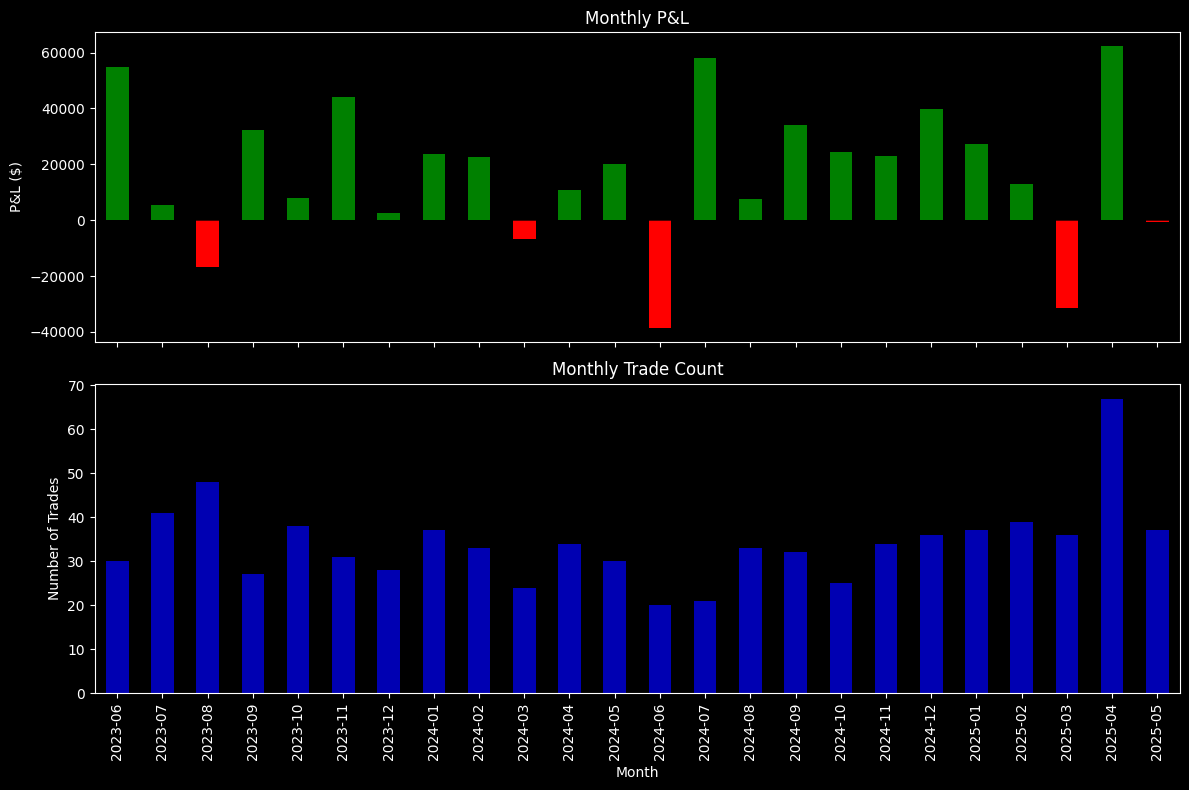


Monthly Statistics:
Average Monthly P&L: $17,517.36
Best Month: $62,226.24
Worst Month: $-38,459.97
Profitable Months: 19 / 24 (79.2%)


In [10]:
# Monthly performance analysis
trades_df['month'] = pd.to_datetime(trades_df['entry_time']).dt.to_period('M')
monthly_pnl = trades_df.groupby('month').agg({
    'pnl': 'sum',
    'entry_time': 'count'
}).rename(columns={'entry_time': 'trades'})

monthly_pnl['win_rate'] = trades_df[trades_df['pnl'] > 0].groupby('month').size() / monthly_pnl['trades'] * 100

print("Monthly Performance:")
print(monthly_pnl.round(2))

# Plot monthly P&L
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# P&L chart
monthly_pnl['pnl'].plot(kind='bar', ax=ax1, color=['green' if x > 0 else 'red' for x in monthly_pnl['pnl']])
ax1.set_title('Monthly P&L')
ax1.set_ylabel('P&L ($)')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Trade count
monthly_pnl['trades'].plot(kind='bar', ax=ax2, color='blue', alpha=0.7)
ax2.set_title('Monthly Trade Count')
ax2.set_ylabel('Number of Trades')
ax2.set_xlabel('Month')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nMonthly Statistics:")
print(f"Average Monthly P&L: ${monthly_pnl['pnl'].mean():,.2f}")
print(f"Best Month: ${monthly_pnl['pnl'].max():,.2f}")
print(f"Worst Month: ${monthly_pnl['pnl'].min():,.2f}")
print(f"Profitable Months: {(monthly_pnl['pnl'] > 0).sum()} / {len(monthly_pnl)} ({(monthly_pnl['pnl'] > 0).sum()/len(monthly_pnl)*100:.1f}%)")

## 8. Run Different Configurations

Let's compare different strategy configurations to see the impact of various features:

In [11]:
# Test different configurations
configs = [
    ("Base (No Optimizations)", {
        "signal_flip_min_profit_pips": 0,
        "signal_flip_min_time_hours": 0,
        "partial_profit_before_sl": False,
        "sl_volatility_adjustment": False,
        "intelligent_sizing": False
    }),
    ("Signal Flip Filters Only", {
        "signal_flip_min_profit_pips": 5.0,
        "signal_flip_min_time_hours": 2.0,
        "partial_profit_before_sl": False,
        "sl_volatility_adjustment": False,
        "intelligent_sizing": False
    }),
    ("With Intelligent Sizing", {
        "signal_flip_min_profit_pips": 5.0,
        "signal_flip_min_time_hours": 2.0,
        "partial_profit_before_sl": False,
        "sl_volatility_adjustment": False,
        "intelligent_sizing": True
    }),
    ("Full Optimization", {
        "signal_flip_min_profit_pips": 5.0,
        "signal_flip_min_time_hours": 2.0,
        "partial_profit_before_sl": True,
        "sl_volatility_adjustment": True,
        "intelligent_sizing": True
    })
]

print("Testing different configurations...")
print(f"{'Configuration':<25} {'Trades':<8} {'Win%':<8} {'P&L':<12} {'Return%':<10} {'Sharpe':<8}")
print("-" * 75)

comparison_results = []
for config_name, settings in configs:
    strategy = create_optimized_strategy(
        initial_capital=100_000,
        **settings
    )
    result = strategy.run_backtest(df_test)
    
    comparison_results.append({
        'name': config_name,
        'trades': result['total_trades'],
        'win_rate': result['win_rate'],
        'pnl': result['total_pnl'],
        'return': result['total_return'],
        'sharpe': result['sharpe_ratio']
    })
    
    print(f"{config_name:<25} {result['total_trades']:<8} "
          f"{result['win_rate']:<8.1f} ${result['total_pnl']:<11,.0f} "
          f"{result['total_return']:<9.1f} {result['sharpe_ratio']:<8.2f}")

# Show improvement
base_pnl = comparison_results[0]['pnl']
full_pnl = comparison_results[-1]['pnl']
improvement = ((full_pnl - base_pnl) / abs(base_pnl)) * 100 if base_pnl != 0 else 0

print(f"\nImprovement from Base to Full Optimization:")
print(f"P&L: ${base_pnl:,.0f} → ${full_pnl:,.0f} ({improvement:+.1f}%)")

Testing different configurations...
Configuration             Trades   Win%     P&L          Return%    Sharpe  
---------------------------------------------------------------------------
Base (No Optimizations)   835      68.7     $166,917     166.9     0.25    
Signal Flip Filters Only  801      68.3     $178,943     178.9     0.26    
With Intelligent Sizing   801      68.3     $293,299     293.3     0.18    
Full Optimization         818      68.8     $420,417     420.4     0.24    

Improvement from Base to Full Optimization:
P&L: $166,917 → $420,417 (+151.9%)


## 9. Strategy Summary

### Key Strategy Components:

1. **Entry Logic**: Requires alignment of all 3 indicators
   - NeuroTrend direction (1 or -1)
   - Market Bias alignment (bullish/bearish)
   - Intelligent Chop in trending regime (1 or 2)

2. **Position Sizing**: Based on NeuroTrend confidence
   - Very Low (<30%): 1M units
   - Low (30-50%): 1M units
   - Medium (50-70%): 3M units
   - High (>70%): 5M units

3. **Risk Management**:
   - Maximum 2% risk per trade
   - Stop loss capped at 45 pips
   - Trailing stop activates at +15 pips, guarantees +5 pip minimum

4. **Exit Strategies**:
   - 3-tier partial take profits (33% each at TP1/TP2/TP3)
   - Signal flip with filters (5+ pips profit, 2+ hours)
   - TP1 pullback exit after hitting TP2

### Usage Tips:

- Best on liquid forex pairs (EURUSD, GBPUSD, AUDUSD, etc.)
- Requires 15-minute or higher timeframe
- Works in both trending and ranging markets
- Adjust `initial_capital` based on your account size
- Monitor drawdown and adjust `risk_per_trade` if needed

Random sample starting from index 5729 (2018-03-26 09:15:00)
Calculating NeuroTrend Intelligent...
Calculating Market Bias...
Calculating Intelligent Chop...
Creating combined plot...
Chart saved to charts/plot_panoramic.png


<Figure size 2000x1600 with 0 Axes>

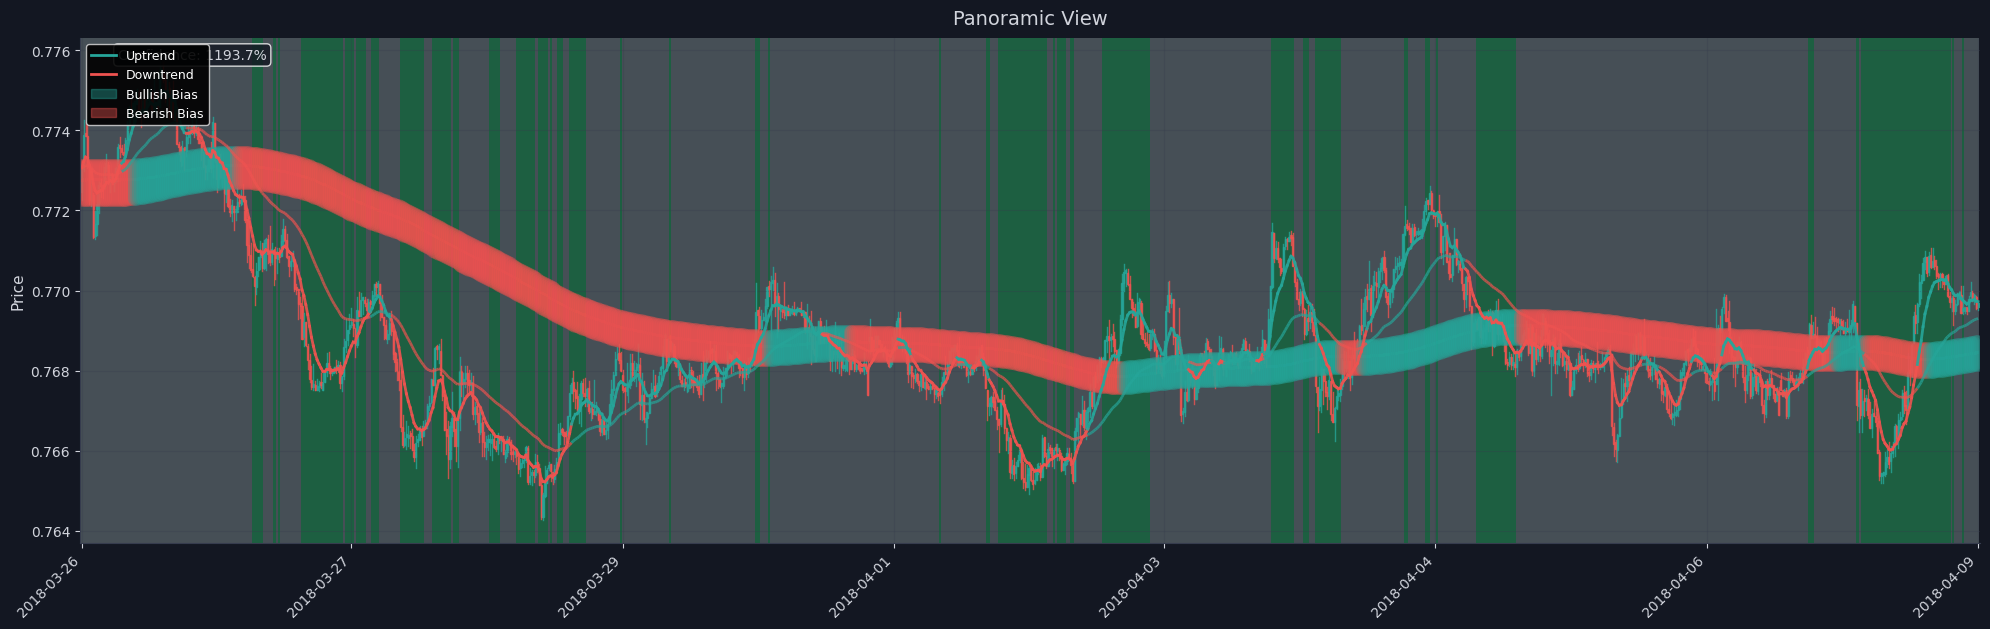

In [12]:
import pandas as pd


from technical_indicators_custom import TIC
from technical_indicators_custom.plotting import IndicatorPlotter
import numpy as np
from technical_indicators_custom.plotting import plot_neurotrend_market_bias_chop



# Initialize the plotter
plotter = IndicatorPlotter()

# Load your OHLC data
df = pd.read_csv('../data/AUDUSD_MASTER_15M.csv')

# Convert DateTime column to datetime and set as index
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)

# Random contiguous sample - select a random starting point and take 1000 consecutive rows
# np.random.seed(42)  # Remove this line for different sample each time
max_start = len(df) - 1000
random_start = np.random.randint(0, max_start)
df_analysis = df.iloc[random_start:random_start + 1000].copy()

print(f"Random sample starting from index {random_start} ({df.index[random_start]})")


# Calculate indicators
print("Calculating NeuroTrend Intelligent...")
df_analysis = TIC.add_neuro_trend_intelligent(
    df_analysis,  
    base_fast=10,
    base_slow=50,
    confirm_bars=3
)   

print("Calculating Market Bias...")
df_analysis = df_analysis = TIC.add_market_bias(df_analysis, ha_len=300, ha_len2=30)  

print("Calculating Intelligent Chop...")
df_analysis = TIC.add_intelligent_chop(df_analysis)
 



# Create the combined plot
print("Creating combined plot...")
# fig = plot_neurotrend_market_bias_chop(
#     df_analysis,
#     title="Panoramic View",
#     figsize=(20, 16),  # Base size
#     save_path='charts/plot_panoramic.png',
#     show=True,
#     show_chop_subplots=False,
#     use_chop_background=True,
#     single_plot_height_ratio=0.4  # Results in 20x3.2
# )


fig = plot_neurotrend_market_bias_chop(
    df_analysis,
    title="Panoramic View",
    figsize=(20, 16),  # Base size
    save_path='charts/plot_panoramic.png',
    show=True,
    show_chop_subplots=False,
    use_chop_background=True,
    single_plot_height_ratio=0.4,  # Results in 20x3.2
    simplified_regime_colors=True,
    trend_color='#2ECC71',  # Hex color
    range_color='#95A5A6'   # Hex color
)





In [ ]:
with pd.option_context('display.max_columns', None):
    print(df_analysis.tail())

                        Open     High      Low    Close  NTI_FastEMA  \
DateTime                                                               
2024-01-26 02:45:00  0.65807  0.65824  0.65777  0.65819     0.658391   
2024-01-26 03:00:00  0.65823  0.65841  0.65781  0.65800     0.658320   
2024-01-26 03:15:00  0.65801  0.65832  0.65798  0.65818     0.658294   
2024-01-26 03:30:00  0.65820  0.65841  0.65795  0.65826     0.658288   
2024-01-26 03:45:00  0.65827  0.65867  0.65824  0.65856     0.658338   

                     NTI_SlowEMA  NTI_SlopePower NTI_TrendPhase  \
DateTime                                                          
2024-01-26 02:45:00     0.658554       -3.115970        Cooling   
2024-01-26 03:00:00     0.658533       -2.383315        Neutral   
2024-01-26 03:15:00     0.658520       -1.546024        Neutral   
2024-01-26 03:30:00     0.658510       -0.974286        Neutral   
2024-01-26 03:45:00     0.658511        0.659803        Neutral   

                     NTI_